## Tutorial 6; Time and Space ##
In this tutorial, we are going to deal with systems that vary simultaneously in space and time. This requires a bit more effort than our simply spatially varying systems. We are going to solve the heat equation using two methods:
1. Individual time and space stepping.
2. The Crank-Nicholson method.

Please refer to lecture and tutorial slides for the derivation of the matrices we are going to use.

In [78]:
import numpy as np
from matplotlib import pyplot as plt

In [79]:
# This time, we are going to have our tri-diagonal-matrix creator as a function, so we don't have to copy paste it!
def TriD(nodes, r=False):
    # I have modified this to include an 'r' term, which is necessary for our CN method.
    # If you don't pass the 'r' to the function, it takes it as false and does the usual 1, -2, 1 matrix. 
    if not r:
        # Create our scaling Tri-Diagonal matrix; we know the format is [zeros] 1, -2, 1 [zeros]
        TriD_Matrix = np.zeros((nodes,nodes)) # Create an empty matrix to begin with
        for i in range(nodes):
            # We are going to construct our matrix row by row
            # we know it's mostly zeros, so let's start with a row of zeros
            Blank_row = np.zeros(nodes)
            # We can then replace the relevant segment of the blank row with 1 or -2 as required:
            if i == 0:
                #This is our first row, only a -2, 1 before the zeros
                Blank_row[i] = -2
                Blank_row[i+1] = 1
            elif i == nodes-1:
                #This is our last row; only zeros, then 1, -2
                Blank_row[i-1] = 1
                Blank_row[i] = -2
            else:
                #These are our middle rows, zeros on either side and then 1, -2, 1
                Blank_row[i-1] = 1
                Blank_row[i] = -2
                Blank_row[i+1] = 1

            # Put this newly generated row in our matrix
            TriD_Matrix[i,:] = Blank_row
    else:
        # Create our scaling Tri-Diagonal matrix; we know the format is [zeros] -r, 1+2r, -r [zeros]
        TriD_Matrix = np.zeros((nodes,nodes)) # Create an empty matrix to begin with
        for i in range(nodes):
            # We are going to construct our matrix row by row
            # we know it's mostly zeros, so let's start with a row of zeros
            Blank_row = np.zeros(nodes)
            # We can then replace the relevant segment of the blank row with 1 or -2 as required:
            if i == 0:
                #This is our first row, only a -2, 1 before the zeros
                Blank_row[i] = 1+2*r
                Blank_row[i+1] = -1*r
            elif i == nodes-1:
                #This is our last row; only zeros, then 1, -2
                Blank_row[i-1] = -1*r
                Blank_row[i] = 1+2*r
            else:
                #These are our middle rows, zeros on either side and then 1, -2, 1
                Blank_row[i-1] = -1*r
                Blank_row[i] = 1+2*r
                Blank_row[i+1] = -1*r

            # Put this newly generated row in our matrix
            TriD_Matrix[i,:] = Blank_row

    return TriD_Matrix

Scale term is too small!: It is 0.010


Text(0.5, 1.0, 'Final temp distribution after 1.00 seconds')

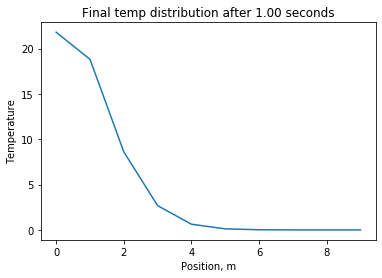

In [80]:
## An implmenentation of the straight forward space-then-time stepping method.

nodes = 10
timestep = 0.01
length = 10
duration = 1 # second

a = length/nodes
Trid_Mat = TriD(nodes)

alpha = 1 # Heat transfer coefficient


# Create our vector of initial temperatures
T_init = np.zeros(nodes)
T_init[0] = 100 # Just putting the edge to be 100 degrees (at the moment)

scale_term = alpha * timestep / (a**2)
# Our scale term needs to be much much smaller than 1 or we might get some instability!
if scale_term < 0.01:
    print("Scale term is OK: %.3f" % scale_term)
else:
    print("Scale term is too small!: It is %.3f" % scale_term)
    
num_timesteps = int(duration//timestep)

T = np.zeros(nodes)
for i in range(num_timesteps):
    if i == 0:
        # This is our initial condition, so we will use T_init
        T = T_init
    else:
        T = T + scale_term*np.matmul(Trid_Mat,T)

# Let's generate an x-vector to plot as our x axis:
x_vec = np.arange(nodes)*a
        
plt.plot(x_vec,T)
plt.xlabel('Position, m')
plt.ylabel('Temperature')
plt.title('Final temp distribution after %.2f seconds' % duration)

Text(0.5, 1.0, 'Final temp distribution after 1.00 seconds')

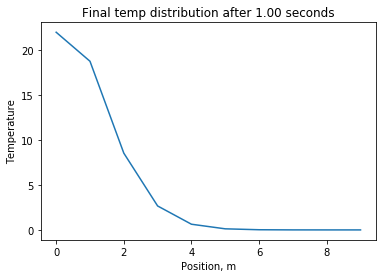

In [81]:
## An implementation of the Crank-Nicolson Method

# Copying the same simulation / initial conditions as last time
nodes = 10
timestep = 0.01
length = 10
duration = 1 # second

a = length/nodes
Trid_Mat = TriD(nodes)

alpha = 1 # Heat transfer coefficient

# Create our vector of initial temperatures
T_init = np.zeros(nodes)
T_init[0] = 100 # Just putting the edge to be 100 degrees (at the moment)

# The CN method has two matrices, which I will call the front and back matrices
# They are generated by passing an 'r' parameter to them
# My function is set up so it generates the front matrix, but if you pass -1*r to the function it will give the back matrix
r = (alpha*timestep)/(2*a**2)

front_mat = TriD(nodes,r)
back_mat = TriD(nodes, -1*r)
#print(front_mat)
#print(back_mat)
# We can now solve the CN method:
num_timesteps = int(duration//timestep)

# I am still using conventional matrix inversion, which is HORRIFYINGLY INEFFICIENT!
T = np.zeros(nodes)
for i in range(num_timesteps):
    if i == 0:
        # This is our initial condition, so we will use T_init
        T = T_init
    else:
        B = np.matmul(back_mat,T)
        T = np.linalg.solve(front_mat,B)
        
# Let's generate an x-vector to plot as our x axis:
x_vec = np.arange(nodes)*a
        
plt.plot(x_vec,T)
plt.xlabel('Position, m')
plt.ylabel('Temperature')
plt.title('Final temp distribution after %.2f seconds' % duration)

**Beginner Task**
1. Have a play around with the implementations above. Find out what discretisation errors are possible (eg poor step sizes in either time or space), and what happens to the solution for each implementation when you go to far. You should find that the CN method is more stable.
2. Decide on your own initial conditions for a sample, and propagate it forward for a certain amount of time. 

**Intermediate Task**:
1. Modify one of the implemementations above to record all values for T across all timesteps, and generate a 2D plot.
1. For the implementation you have done above, determine **when** the system reaches a thermal equilibrium.

**Advanced Task**: 
1. Determine how to put non-zero boundary conditions our CN equation (i.e. no longer having T0 = T[-1] = 0 in the original derivation). Note that as these BCs exist outside the simulation domain, they **should not change over time**.
2. Implement the boundary conditions of T0 = 100, T[-1] = 0, and find the equilibrium value.
